In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import (GridSearchCV, KFold, StratifiedKFold,
                                     train_test_split)
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

df = pd.read_csv(
    "/home/aggelos/projects/MobilityModeling/dataset.csv", index_col=0)
series = df['3CLTE']

# transform time series into supervised learning format


def series_to_supervised(sequence, lookback, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + lookback
        if end_ix > len(sequence) - 1:
            break

        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def evaluate(predictions, actual):
    mse = mean_squared_error(actual, predictions)
    mae = mean_absolute_error(actual, predictions)
    mape = mean_absolute_percentage_error(actual, predictions)
    rmse = math.sqrt(mse)
    return rmse, mae, mape


def rolling_evaluation(predictor, x_test, y_test, lookback, count=1):

    predictions = list()
    actual = list()
    for i in range(len(test)):
        x_input = X_test[i, :]
        x_input = x_input.reshape((1, lookback))
        yhat = predictor.predict(x_input)
        predictions.append(yhat[0])
        actual.append(test[i, -1:])

    if count == 1:
        # plot predictions and expected results
        plt.plot(y_train[800:])
        plt.plot([None for i in y_train[800:]] + [x for x in y_test])
        plt.plot([None for i in y_train[800:]] + [x for x in predictions])
        plt.xlabel('Time')
        plt.ylabel('DataRate (MB)')
        plt.title('DataRate Over Time')
        plt.legend(['Train_y', 'Actual', 'Prediction'])
        plt.show()

    rmse, mae, mape = evaluate(predictions, actual)

    return rmse, mae, mape


def fit_mlp(X_train, y_train):

    inputs = Input(shape=(X_train.shape[1:]))

    x = Flatten()(inputs)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)

    pred = Dense(1)(x)

    model = Model(inputs, pred)

    opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

    model.compile(loss='mse', optimizer=opt)

    history = model.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=20,
        validation_split=0.1,
        verbose=0)

    return model, history

    # Lets build the model


def fit_gru(X_train, y_train):

    inputs = Input(shape=(X_train.shape[1:]))

    x = GRU(128, return_sequences=True)(inputs)
    x = Dropout(0.5)(x)

    x = GRU(128, return_sequences=True)(x)
    x = Dropout(0.5)(x)

    x = GRU(128)(x)
    x = Dropout(0.5)(x)

    pred = Dense(1)(x)

    model = Model(inputs, pred)

    opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

    model.compile(loss='mse', optimizer=opt)

    history = model.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=20,
        verbose=0,
        validation_split=0.1)

    return model, history


def fit_fcn(X_train, y_train):

    inputs = Input(shape=(X_train.shape[1:]))

    x = Conv1D(64, 4, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(64, 4, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(64, 4, padding='same')(x)
    #x = Activation('relu')(x)

    x = GlobalMaxPooling1D()(x)

    prediction = Dense(1)(x)

    model = Model(inputs, prediction)

    model.compile(
        loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.001, decay=1e-6))

    history = model.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=20,
        validation_split=0.1,
        verbose=0)

    return model, history


def fit_cnn_gru(X_train, y_train):
    inputs = Input(X_train.shape[1:])

    x = Conv1D(16, 2, activation='relu')(inputs)

    x = GRU(64, activation='relu')(x)

    x = Dropout(0.5)(x)

    preds = Dense(1)(x)

    model = Model(inputs, preds)

    model.compile(
        loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.001, decay=1e-6))

    history = model.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=20,
        validation_split=0.1,
        verbose=0)

    return model, history


lookback = 32
scaler = MinMaxScaler()

train, test = train_test_split(df.values)

X_train = train[:, :-1]
X_train = scaler.fit_transform(X_train)
# X_train = X_train.reshape((1, lookback))
y_train = train[-797:, -1]

X_test = test[:, :-1]
X_test = scaler.fit_transform(X_test)
y_test = test[:, -1]

X_train = series_to_supervised(X_train, lookback, 1)
print(X_train.shape)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = series_to_supervised(X_test, lookback, 1)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)

cnn_gru, _ = fit_cnn_gru(X_train, y_train)
cnn_gru_preds = cnn_gru.predict(X_test)

mlp, _ = fit_mlp(X_train, y_train)
mlp_preds = mlp.predict(X_test)

gru, _ = fit_gru(X_train, y_train)
gru_preds = gru.predict(X_test)

fcn, _ = fit_fcn(X_train, y_train)
fcn_preds = fcn.predict(X_test)

predictions = (mlp_preds[-210:, :] + fcn_preds[-210:, :] + gru_preds[-210:, :]
               + cnn_gru_preds[-210:, :]) / 4
predictions = pd.DataFrame({
    'mlp': mlp_preds[-210:, 1],
    'gru': gru_preds[-210:, 1],
    'fcn': fcn_preds[-210:, 1],
    'cnn-gru': cnn_gru_preds[-210:, 1]
})
data = pd.DataFrame({
    'mlp': mlp_preds[-210:, 1],
    'gru': gru_preds[-210:, 1],
    'fcn': fcn_preds[-210:, 1],
    'cnn-gru': cnn_gru_preds[-210:, 1],
    'actual': y_test[-210:]
})  # print(data)
predictions = predictions.values

y = y_test[-210:]

X_test = predictions[-50:, :]
x_train = predictions[:-50, :]

y_test = y[-50:]
y_train = y[:-50]


def nn(X_train, y_train):
    inputs = Input(shape=(4, ))
    x = Dense(64, activation='linear')(inputs)
    output = Dense(1)(x)

    model = Model(inputs, output)
    model.compile(optimizer='adam', loss='mse')

    stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=0,
        patience=30,
        verbose=0,
        mode='auto',
        baseline=None)

    history = model.fit(
        X_train,
        y_train,
        verbose=0,
        epochs=800,
        validation_split=0.2,
        callbacks=[stop])

    return model, history


AttributeError: 'tuple' object has no attribute 'shape'

In [16]:
import math

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import (GridSearchCV, KFold, StratifiedKFold,
                                     train_test_split)
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

df = pd.read_csv(
    "/home/aggelos/projects/MobilityModeling/dataset.csv", index_col=0)
series = df['3CLTE']

# transform time series into supervised learning format


def series_to_supervised(sequence, lookback, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + lookback
        if end_ix > len(sequence) - 1:
            break

        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def evaluate(predictions, actual):
    mse = mean_squared_error(actual, predictions)
    mae = mean_absolute_error(actual, predictions)
    mape = mean_absolute_percentage_error(actual, predictions)
    rmse = math.sqrt(mse)
    return rmse, mae, mape


def rolling_evaluation(predictor, x_test, y_test, lookback, count=1):

    predictions = list()
    actual = list()
    for i in range(len(test)):
        x_input = X_test[i, :]
        x_input = x_input.reshape((1, lookback))
        yhat = predictor.predict(x_input)
        predictions.append(yhat[0])
        actual.append(test[i, -1:])

    if count == 1:
        # plot predictions and expected results
        plt.plot(y_train[800:])
        plt.plot([None for i in y_train[800:]] + [x for x in y_test])
        plt.plot([None for i in y_train[800:]] + [x for x in predictions])
        plt.xlabel('Time')
        plt.ylabel('DataRate (MB)')
        plt.title('DataRate Over Time')
        plt.legend(['Train_y', 'Actual', 'Prediction'])
        plt.show()

    rmse, mae, mape = evaluate(predictions, actual)

    return rmse, mae, mape


def fit_mlp(X_train, y_train):

    inputs = Input(shape=(X_train.shape[1:]))

    x = Flatten()(inputs)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)

    pred = Dense(1)(x)

    model = Model(inputs, pred)

    opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

    model.compile(loss='mse', optimizer=opt)

    history = model.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=20,
        validation_split=0.1,
        verbose=1)

    return model, history

    # Lets build the model


def fit_gru(X_train, y_train):

    inputs = Input(shape=(X_train.shape[1:]))

    x = GRU(128, return_sequences=True)(inputs)
    x = Dropout(0.5)(x)

    x = GRU(128, return_sequences=True)(x)
    x = Dropout(0.5)(x)

    x = GRU(128)(x)
    x = Dropout(0.5)(x)

    pred = Dense(1)(x)

    model = Model(inputs, pred)

    opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

    model.compile(loss='mse', optimizer=opt)

    history = model.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=20,
        verbose=0,
        validation_split=0.1)

    return model, history


def fit_fcn(X_train, y_train):

    inputs = Input(shape=(X_train.shape[1:]))

    x = Conv1D(64, 4, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(64, 4, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(64, 4, padding='same')(x)
    #x = Activation('relu')(x)

    x = GlobalMaxPooling1D()(x)

    prediction = Dense(1)(x)

    model = Model(inputs, prediction)

    model.compile(
        loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.001, decay=1e-6))

    history = model.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=20,
        validation_split=0.1,
        verbose=0)

    return model, history


def fit_cnn_gru(X_train, y_train):
    inputs = Input(X_train.shape[1:])

    x = Conv1D(16, 2, activation='relu')(inputs)

    x = GRU(64, activation='relu')(x)

    x = Dropout(0.5)(x)

    preds = Dense(1)(x)

    model = Model(inputs, preds)

    model.compile(
        loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.001, decay=1e-6))

    history = model.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=20,
        validation_split=0.1,
        verbose=0)

    return model, history

In [27]:
df = pd.read_csv(
    "/home/aggelos/projects/MobilityModeling/dataset.csv", index_col=0)
series = df['3CLTE']
lookback = 32
scaler = MinMaxScaler()
df = scaler.fit_transform(df)
#df = pd.DataFrame(df)
#df = df.dropna(inplace=True)
train, test = train_test_split(df)




X_train, y_train = series_to_supervised(train, lookback, 1)
y_train = y_train[:,5]
print(X_train.shape, y_train.shape)
X_test, y_test = series_to_supervised(test, lookback, 1)
y_test = y_test[:,5]


print(X_test.shape, y_test.shape)

(1021, 32, 13) (1021,)
(319, 32, 13) (319,)


In [28]:
train

array([[4.43080195e-01, 3.44295517e-02, 2.87629946e-02, ...,
        1.64443593e-01, 1.87554429e-01, 9.69135792e-02],
       [1.40462719e-01, 1.14585186e-01, 1.13070515e-01, ...,
        6.78196313e-02, 5.51114053e-02, 1.09194103e-01],
       [2.41406215e-02, 7.80449691e-03, 2.41783863e-02, ...,
        1.06355780e-02, 3.52906976e-02, 1.92275107e-02],
       ...,
       [1.45312736e-01, 1.78094360e-01, 7.57002635e-02, ...,
        2.31133123e-02, 1.52379838e-01, 8.09105401e-02],
       [1.25917942e-01, 7.64083063e-02, 1.90383128e-01, ...,
        6.25422480e-02, 1.07346884e-01, 2.21813532e-01],
       [3.95484749e-02, 1.84788788e-02, 6.97592759e-02, ...,
        4.27923848e-04, 6.53051128e-03, 1.74050638e-02]])

Train on 918 samples, validate on 103 samples
Epoch 1/20
918/918 [==============================] - 0s 395us/step - loss: nan - val_loss: nan
Epoch 2/20
918/918 [==============================] - 0s 36us/step - loss: nan - val_loss: nan
Epoch 3/20
918/918 [==============================] - 0s 37us/step - loss: nan - val_loss: nan
Epoch 4/20
918/918 [==============================] - 0s 35us/step - loss: nan - val_loss: nan
Epoch 5/20
918/918 [==============================] - 0s 35us/step - loss: nan - val_loss: nan
Epoch 6/20
918/918 [==============================] - 0s 35us/step - loss: nan - val_loss: nan
Epoch 7/20
918/918 [==============================] - 0s 36us/step - loss: nan - val_loss: nan
Epoch 8/20
918/918 [==============================] - 0s 37us/step - loss: nan - val_loss: nan
Epoch 9/20
918/918 [==============================] - 0s 34us/step - loss: nan - val_loss: nan
Epoch 10/20
918/918 [==============================] - 0s 37us/step - loss: nan - val_loss: nan
Ep

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff7d407de10>,
      dtype=object)

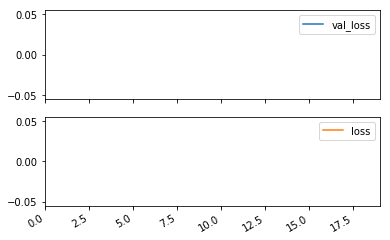

In [22]:
mlp, history = fit_mlp(X_train, y_train)
history = pd.DataFrame(history.history)
history.plot(subplots=True)